In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import (accuracy_score, f1_score, precision_recall_curve, auc, log_loss, 
                             classification_report, plot_confusion_matrix, roc_curve)

Since the pre-designated test dataset does not have include values for the target feature, the train dataset will be split further into a train/test set.

In [2]:
#train = pd.read_csv('../data/Train.csv', index_col=0)
#test = pd.read_csv('../data/Test.csv', index_col=0)

train = pd.read_csv('../data/Train.csv', index_col=0)
test = pd.read_csv('../data/Test.csv', index_col=0)

train.shape, test.shape

((13710, 39), (4570, 39), (13710,), (4570,))

In [3]:
train['target'] = train['target'].astype('int64')
test['target'] = test['target'].astype('int64')

In [4]:
# Split into test/train

X_train, y_train = train.drop(columns=['target', 'enrollee_id']), train.target
X_test, y_test = test.drop(columns=['target', 'enrollee_id']), test.target

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [5]:
# Scale Data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 0. Baseline Model

In [6]:
pd.DataFrame({
    'Counts':y_train.value_counts(),
    '%':y_train.value_counts()/len(y_train)*100
})

,Counts,%
0.0,10322,75.288111
1.0,3388,24.711889


As the majority response is 0 (most candidates are not looking for a job change), a baseline ZeroR classifier will be used as a basis of comparison for other models.

In [7]:
# Create a y_pred that is a series of 0s

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0, digits=5))

              precision    recall  f1-score   support

         0.0    1.00000   0.75274   0.85893      4570
         1.0    0.00000   0.00000   0.00000         0

    accuracy                        0.75274      4570
   macro avg    0.50000   0.37637   0.42946      4570
weighted avg    1.00000   0.75274   0.85893      4570



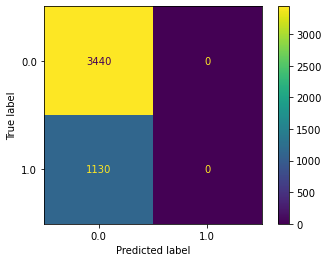

In [8]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.7527

# I. Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8144    0.9084    0.8589      3440
         1.0     0.5703    0.3699    0.4487      1130

    accuracy                         0.7753      4570
   macro avg     0.6923    0.6392    0.6538      4570
weighted avg     0.7541    0.7753    0.7575      4570



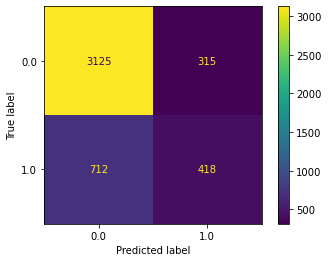

In [11]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

This model performs somewhat better than the baseline. Next, I'll try to optimize performance with Grid Search cross validation

{0: 0.1, 1: 0.9}    41.684902
{0: 0.2, 1: 0.8}    66.411379
{0: 0.3, 1: 0.7}    75.842451
{0: 0.4, 1: 0.6}    77.549234
{0: 0.5, 1: 0.5}    77.527352
dtype: float64


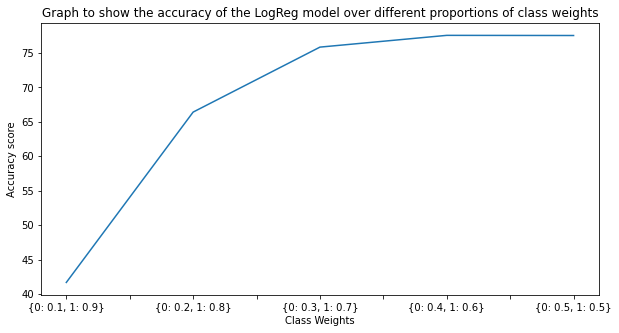

Wall time: 637 ms


In [12]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

acc = []

for i in class_weight:
    lm = LogisticRegression(class_weight=i, random_state=0)
    lm.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, lm.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=class_weight)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the LogReg model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

In [13]:
# Make pipeline
LR_pipeline = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

# Define parameters
params_LR = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    'LR__penalty': ['l2', 'l1',],
    'LR__solver': ['liblinear', 'saga'],
    'LR__class_weight': class_weight
}

In [14]:
%%time

gridcv_LR = GridSearchCV(LR_pipeline, param_grid=params_LR, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 33 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'LR__C': [0.001, 0.1, 1, 10, 100],
                         'LR__class_weight': [{0: 0.1, 1: 0.9},
                                              {0: 0.2, 1: 0.8},
                                              {0: 0.3, 1: 0.7},
                                              {0: 0.4, 1: 0.6},
                                              {0: 0.5, 1: 0.5}],
                         'LR__penalty': ['l2', 'l1'],
                         'LR__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=10)

In [15]:
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6},
                                     solver='saga'))]),
 {'LR__C': 0.1,
  'LR__class_weight': {0: 0.4, 1: 0.6},
  'LR__penalty': 'l2',
  'LR__solver': 'saga'},
 0.7835886214442013)

In [16]:
LR_best = gridcv_LR.best_estimator_

y_pred = LR_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8296    0.8820    0.8550      3440
         1.0     0.5553    0.4487    0.4963      1130

    accuracy                         0.7748      4570
   macro avg     0.6925    0.6653    0.6757      4570
weighted avg     0.7618    0.7748    0.7663      4570



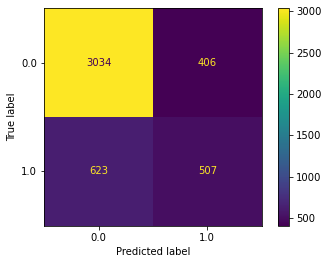

In [17]:
plot_confusion_matrix(LR_best, X_test, y_test);

The optimized logistic regression model performs about the same as the one with default settings.

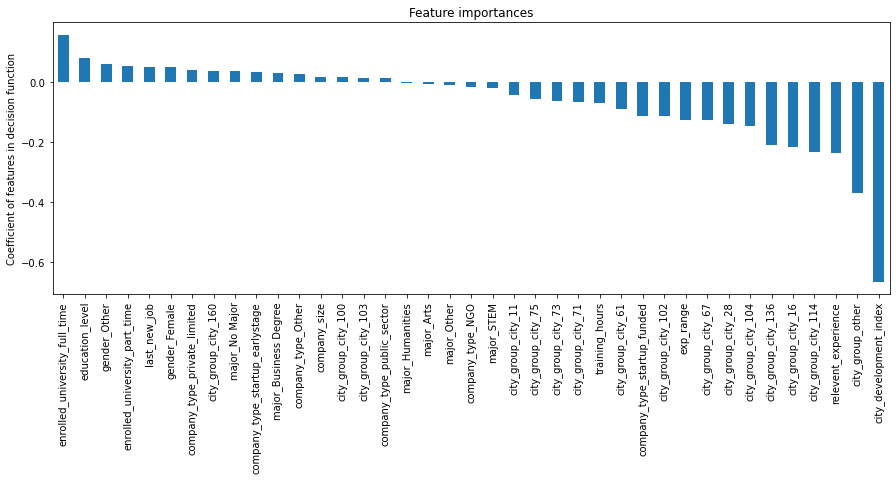

In [18]:
# Plot feature importance

importance = LR_best.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

It seems nearly a third of the features have close to 0 impact in the model, though present enrollment and gender female/other seem to be strong predictors of a positive case

--------------------------------------------------------------------

# II. Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8099    0.8767    0.8420      3440
         1.0     0.4988    0.3735    0.4271      1130

    accuracy                         0.7523      4570
   macro avg     0.6543    0.6251    0.6346      4570
weighted avg     0.7330    0.7523    0.7394      4570



The default RF model performs slightly worse than the LogReg models.

{0: 0.1, 1: 0.9}    75.382932
{0: 0.2, 1: 0.8}    75.273523
{0: 0.3, 1: 0.7}    75.207877
{0: 0.4, 1: 0.6}    75.579869
{0: 0.5, 1: 0.5}    75.229759
dtype: float64


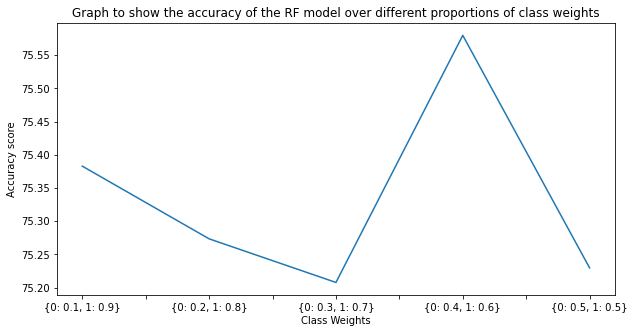

Wall time: 8.18 s


In [20]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

acc = []

for i in class_weight:
    clf = RandomForestClassifier(class_weight=i, random_state=0)
    clf.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, clf.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=class_weight)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the RF model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

It seems slightly under unbalanced (0.4 : 0.6) is optimal.

In [21]:
# Get a sense of the range of depths on default RF model

RF_depths = []

for i in range(len(RF.estimators_)):
    RF_depths.append(RF.estimators_[i].tree_.max_depth)
    
min(RF_depths), max(RF_depths)

(35, 50)

We can limit hyperparameter search to about this range of max depth.

In [22]:
# Make pipeline
RF_pipeline = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier())])

# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_RF = {
    'RF__n_estimators': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    'RF__max_depth': [10, 15, 20, 30, 50, 60], 
    #'RF__max_features': ['sqrt', 'log2', None], 
    #'RF__criterion': ['gini', 'entropy'],
    'RF__class_weight': class_weight
}

In [23]:
%%time

RF_gridcv = GridSearchCV(RF_pipeline, params_RF, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
RF_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 9min 46s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RF__class_weight': [{0: 0.1, 1: 0.9},
                                              {0: 0.2, 1: 0.8},
                                              {0: 0.3, 1: 0.7},
                                              {0: 0.4, 1: 0.6},
                                              {0: 0.5, 1: 0.5}],
                         'RF__max_depth': [10, 15, 20, 30, 50, 60],
                         'RF__n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

In [24]:
RF_gridcv.best_estimator_, RF_gridcv.best_params_, RF_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('RF',
                  RandomForestClassifier(class_weight={0: 0.4, 1: 0.6},
                                         max_depth=10))]),
 {'RF__class_weight': {0: 0.4, 1: 0.6},
  'RF__max_depth': 10,
  'RF__n_estimators': 100},
 0.788475565280817)

In [25]:
RF_best = RF_gridcv.best_estimator_

y_pred = RF_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8402    0.8756    0.8575      3440
         1.0     0.5655    0.4929    0.5267      1130

    accuracy                         0.7810      4570
   macro avg     0.7028    0.6843    0.6921      4570
weighted avg     0.7722    0.7810    0.7757      4570



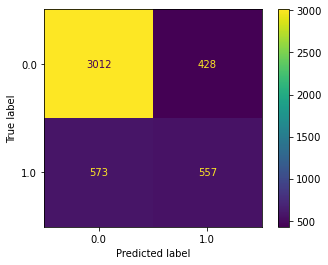

In [26]:
plot_confusion_matrix(RF_best, X_test, y_test);

The tuned model is definitely better than the default RF!

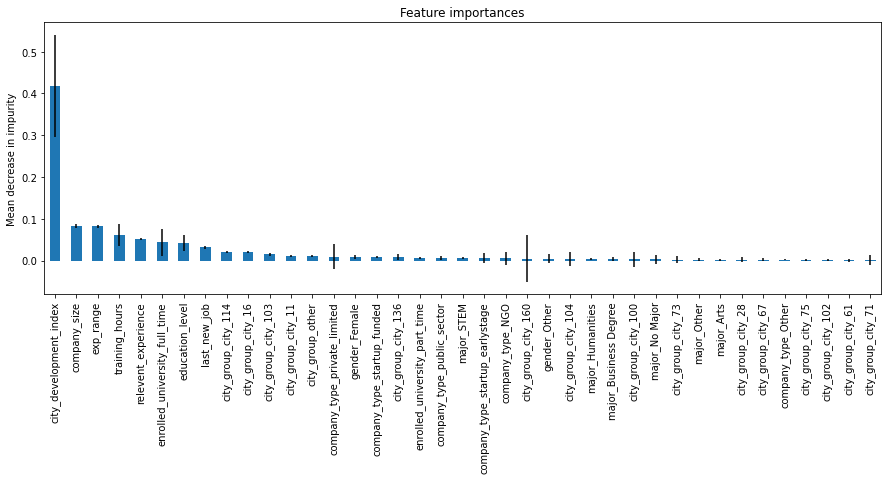

In [27]:
# Viewing feature importances

importance = RF_best.named_steps.RF.feature_importances_
forest_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in RF_best.named_steps.RF.estimators_], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(15,5))

forest_imp.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90);

--------------------------------------------------------------------------

# III. Support Vector Machine

### a) Linear SVC

In [28]:
from sklearn.svm import LinearSVC

In [29]:
# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_lin = {
    'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
    'SVC_Linear__class_weight': class_weight,
    'SVC_Linear__max_iter': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    #'SVC_Linear__dual': [False]
}

In [30]:
%%time

# Grid search for optimal hyperparameters

SVC_linear = Pipeline([('scaler', StandardScaler()), ('SVC_Linear', LinearSVC(dual=False, random_state=0))])

SVC_lin_gridcv = GridSearchCV(SVC_linear, params_SVC_lin, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
SVC_lin_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 24.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC_Linear',
                                        LinearSVC(dual=False,
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'SVC_Linear__class_weight': [{0: 0.1, 1: 0.9},
                                                      {0: 0.2, 1: 0.8},
                                                      {0: 0.3, 1: 0.7},
                                                      {0: 0.4, 1: 0.6},
                                                      {0: 0.5, 1: 0.5}],
                         'SVC_Linear__max_iter': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

In [31]:
SVC_lin_gridcv.best_estimator_, SVC_lin_gridcv.best_params_, SVC_lin_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC_Linear',
                  LinearSVC(C=0.01, class_weight={0: 0.4, 1: 0.6}, dual=False,
                            max_iter=100, random_state=0))]),
 {'SVC_Linear__C': 0.01,
  'SVC_Linear__class_weight': {0: 0.4, 1: 0.6},
  'SVC_Linear__max_iter': 100},
 0.7844638949671772)

In [32]:
SVC_linear_best = SVC_lin_gridcv.best_estimator_

y_pred = SVC_linear_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8283    0.8860    0.8562      3440
         1.0     0.5596    0.4407    0.4931      1130

    accuracy                         0.7759      4570
   macro avg     0.6939    0.6634    0.6746      4570
weighted avg     0.7618    0.7759    0.7664      4570



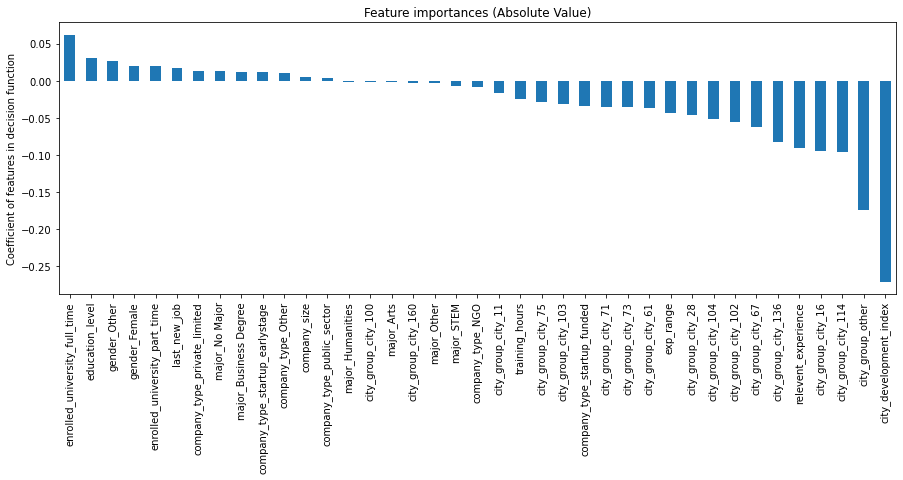

In [33]:
# Plot feature importance

importance = SVC_linear_best.named_steps.SVC_Linear.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances (Absolute Value)")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

Again, high predictors of a positive case are current university enrollment and non-male gender.

### b) SVC (nonlinear kernels)

In [34]:
from sklearn.svm import SVC

0.001     75.273523
0.010     75.273523
0.100     77.702407
0.500     77.964989
1.000     77.943107
2.000     77.921225
5.000     77.768053
10.000    77.680525
dtype: float64


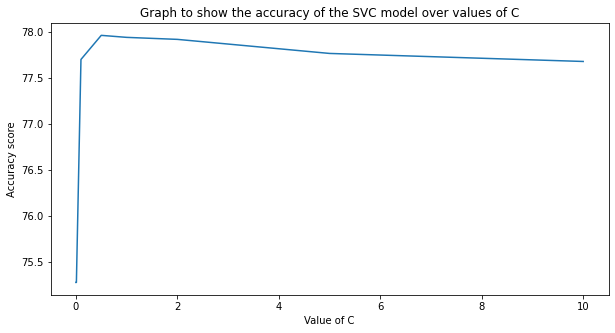

Wall time: 1min 48s


In [35]:
%%time

# Print accuracy along different values of c
c_range = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10]
acc = []

for i in c_range:
    svc = SVC(C=i, random_state=0)
    svc.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, svc.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=c_range)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the SVC model over values of C')
plt.xlabel('Value of C')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

It appears the optimal value of c is 0.5, though accuracy doesn't vary by much.

#### RBF Kernel

In [36]:
# Make pipeline
SVC_nonlinear = Pipeline([('scaler', StandardScaler()), ('SVC', SVC(random_state=0))])

# Define param grid
class_weight = [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_rbf = {
    'SVC__kernel': ['rbf'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
    'SVC__class_weight': class_weight
}

In [37]:
%%time

# Grid search
SVC_rbf_gridcv = GridSearchCV(SVC_nonlinear, params_SVC_rbf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
SVC_rbf_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Wall time: 29min 5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.1, 0.5, 1, 2, 5],
                         'SVC__class_weight': [{0: 0.3, 1: 0.7},
                                               {0: 0.4, 1: 0.6},
                                               {0: 0.5, 1: 0.5}],
                         'SVC__gamma': [0.0001, 0.001, 0.01, 1, 10],
                         'SVC__kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [38]:
SVC_rbf_gridcv.best_estimator_, SVC_rbf_gridcv.best_params_, SVC_rbf_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC',
                  SVC(C=2, class_weight={0: 0.4, 1: 0.6}, gamma=0.001,
                      random_state=0))]),
 {'SVC__C': 2,
  'SVC__class_weight': {0: 0.4, 1: 0.6},
  'SVC__gamma': 0.001,
  'SVC__kernel': 'rbf'},
 0.7850474106491612)

In [39]:
SVC_rbf_best = SVC_rbf_gridcv.best_estimator_

y_pred = SVC_rbf_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8263    0.8977    0.8605      3440
         1.0     0.5774    0.4257    0.4901      1130

    accuracy                         0.7810      4570
   macro avg     0.7019    0.6617    0.6753      4570
weighted avg     0.7648    0.7810    0.7689      4570



----------------------------------------------------------------------

# IV. XGBoost Model

In [56]:
%%time

import xgboost as xgb

XGB = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=0, eval_metric='error')

XGB.fit(X_train_scaled, y_train)
y_pred = XGB.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8204    0.8831    0.8506      3440
         1.0     0.5363    0.4115    0.4657      1130

    accuracy                         0.7665      4570
   macro avg     0.6784    0.6473    0.6582      4570
weighted avg     0.7502    0.7665    0.7554      4570

Wall time: 880 ms


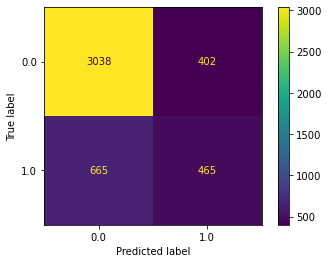

In [42]:
plot_confusion_matrix(XGB, X_test_scaled, y_test);

The default xgb model performs only slightly better than the baseline dummy model.

1     77.986871
3     78.074398
6     78.293217
9     78.402626
12    78.271335
15    78.140044
dtype: float64


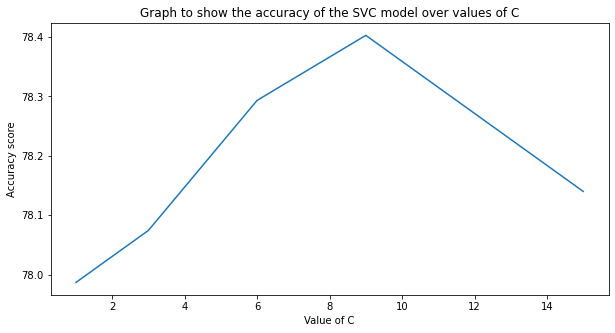

Wall time: 594 ms


In [69]:
%%time

# Print accuracy along different values of c
max_d = [1, 3, 6, 9, 12, 15]
acc = []

for i in max_d:
    clf = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='error', 
                           gamma=i, n_estimators=10, random_state=0)
    clf.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, clf.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=max_d)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the SVC model over values of C')
plt.xlabel('Value of C')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

In [70]:
# Make pipeline
xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('XGB', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                                               eval_metric='error', random_state=0))])

# Define param grid
class_weight = [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_xgb = {
    'XGB__n_estimators': [5, 10, 15, 20, 30, 40, 50], 
    'XGB__max_depth': [5, 10, 15], 
    'XGB__gamma': [2, 6, 10], 
    #'XGB__learning_rate': [], 
    #'XGB__': [], 
}

In [71]:
%%time

# Grid search
xgb_gridcv = GridSearchCV(xgb_pipe, params_xgb, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
xgb_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Wall time: 1min 4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='error',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                          

In [75]:
xgb_gridcv.best_estimator_, xgb_gridcv.best_params_, xgb_gridcv.best_score_

XGB_best = xgb_gridcv.best_estimator_

y_pred = XGB_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.8334    0.8869    0.8593      3440
         1.0     0.5721    0.4602    0.5101      1130

    accuracy                         0.7814      4570
   macro avg     0.7027    0.6735    0.6847      4570
weighted avg     0.7688    0.7814    0.7730      4570



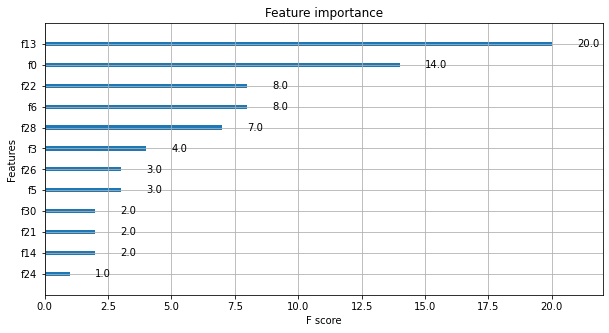

In [76]:
fig, ax = plt.subplots(figsize = (10, 5));
xgb.plot_importance(XGB_best.named_steps.XGB, ax=ax);

----------------------------------------------------

# V. Select Best Model

In [77]:
models = [
    ('Dummy (Baseline)', dummy),
    ('LogReg', LR),
    ('LogReg_best', LR_best), 
    ('RandomForest', RF),
    ('RandomForest_best', RF_best),
    ('SVC_Linear', SVC_linear_best),
    ('SVC_RBF', SVC_rbf_best),
    ('XGB', XGB),
    ('XGB_best', XGB_best)
]

scoring = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']

In [78]:
%%time
%%capture --no-display

results= {}
for name, model in models:
    results[name] = {}
    for i in scoring:        
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=5, return_train_score=True)
        results[name][i] = scores

Wall time: 7min 34s


In [79]:
Precision_Test = []
Recall_Test = []
Accuracy_Train = []
Accuracy_Test = []
F1_Test = []
AUC_Test = []

for model in results.keys():
    # Precision
    pr_test_mean = results[model]['precision']['test_score'].mean()*100
    Precision_Test.append(round(pr_test_mean, 2))
    
    # Recall
    rec_test_mean = results[model]['recall']['test_score'].mean()*100
    Recall_Test.append(round(rec_test_mean, 2))
    
    # Accuracy
    acc_train_mean = results[model]['accuracy']['train_score'].mean()*100
    acc_test_mean = results[model]['accuracy']['test_score'].mean()*100
    Accuracy_Train.append(round(acc_train_mean, 2))
    Accuracy_Test.append(round(acc_test_mean, 2))
    
    # F1
    f1_test_mean = results[model]['f1']['test_score'].mean()*100
    F1_Test.append(round(f1_test_mean, 2))
    
    # AUC
    auc_test_mean = results[model]['roc_auc']['test_score'].mean()
    AUC_Test.append(round(auc_test_mean, 4))
    
# Save model names and parameters as list
names = []
steps = []
for name, model in models:
    names.append(str(name))
    if hasattr(model, 'named_steps'):
        steps.append(str(list(model.named_steps.values())[1]))
    else:
        steps.append(model)

In [80]:
#pd.options.display.max_colwidth = 100

model_compare = pd.DataFrame(
    {'Model': names,
     'Precision_Test': Precision_Test,
     'Recall_Test': Recall_Test,
     'Acc_Train': Accuracy_Train, 'Acc_Test': Accuracy_Test,
     'F1_Test': F1_Test,
     'AUC_Test': AUC_Test,
     #'Parameters': steps
    }
)

model_compare

,Model,Precision_Test,Recall_Test,Acc_Train,Acc_Test,F1_Test,AUC_Test
0,Dummy (Baseline),0.00,0.00,75.29,75.29,0.00,0.5000
1,LogReg,60.25,24.91,77.36,77.40,34.96,0.7441
2,LogReg_best,58.05,44.92,78.35,78.35,50.64,0.7551
3,RandomForest,54.08,38.75,99.70,76.75,45.12,0.7498
4,RandomForest_best,58.58,48.35,80.77,78.85,52.89,0.7795
5,SVC_Linear,58.42,44.45,78.50,78.45,50.48,0.7551
6,SVC_RBF,59.28,41.71,78.50,78.50,48.96,0.7350
7,XGB,55.65,40.94,87.03,77.35,47.16,0.7710
8,XGB_best,59.25,46.55,79.01,78.85,52.11,0.7739
